# Swing-up control via trajectory optimization

In the previous notebook we developed a simple heuristic nonlinear controller that was able to add enough energy to the system to drive it to a nearly upright position.  The controller then switched to a dual-PID strategy for balancing.

However, this type of "energy-shaping" control is generally limited to relatively simple systems and objectives; for example, it is not easily applied to control of spacecraft trajectories, multirotor aircraft, or complex robots.  _Trajectory optimization_ is a much more powerful and general control strategy for these kinds of systems.

In this notebook we will develop a feedforward controller that combines a pre-computed optimal trajectory with online stabilization to assist the system in executing the planned motion.  We will see the system perform a much more aggressive swing-up maneuver compared to the previous energy-shaping controller.

In [18]:
import os, sys

import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

import collimator
from collimator import library
from collimator.library.quanser import animate_qube

from controllers import *

plt.rcParams['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'  # Change to your local path

HOME = os.path.expanduser("~")
sys.path.append(f"{HOME}/Quanser/libraries/python")

# Connect to physical hardware or QLabs simulation?
HARDWARE = True
version = 3 if HARDWARE else 2

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Let's start by planning the swing-up trajectory offline.  We will do this by numerically solving the optimal control problem

$$
\begin{gather*}
\min_{x, u} J(x, u)
\\
\text{subject to} \qquad \begin{cases} \dot{x} = f(t, x, u) \\ x(t_f) = x_f \end{cases}
\\
J(x, u) = \tilde{x}(t_f)^T Q \tilde{x}(t_f) + \int_0^{t_f} \left[ \tilde{x}^T Q \tilde{x} + u^T R u \right] ~ dt,
\end{gather*}
$$

where $x_f$ is the target state, $f(t, x, u)$ is the nonlinear dynamics model, $\tilde{x}(t) = x(t) - x_f$, and $Q$ and $R$ are the state and cost weight matrices as in the LQR control design.

There are a wide variety of ways to formulate and discretize optimal control problems; this is just what we will use for this particular case.  The built-in function `trajopt` will solve this type of problem using a standard Hermite-Simpson direct collocation method where the state as a function of time is discretized with a piecewise cubic polynomial and the control is likewise discretized with a piecewise linear function.  The resulting constrained nonlinear optimization problem is solved using IPOPT.

Note that the `trajopt` function allows for more flexibility than we need for this problem, including time-varying nominal trajectories and bounds on the state.

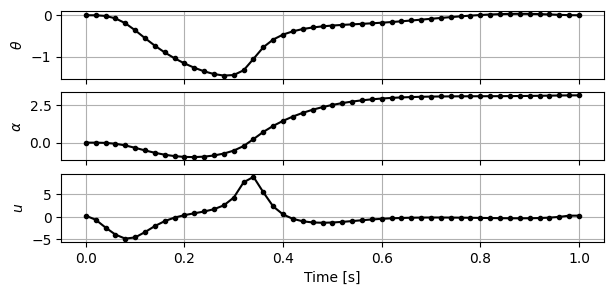

In [19]:
plant = library.QubeServoModel(full_state_output=True, name="qube")

nx, nu, ny = 4, 1, 2                     # State, control, measurement dimensions
t0, tf = 0.0, 1.0                        # Initial and final times
x0 = np.array([0.0, 0.0, 0.0, 0.0])      # Initial state
xf = np.array([0.0, np.pi, 0.0, 0.0])    # Target state
N = 50                                   # Discretization points

# Optimize the swing-up trajectory, constraining only the final state
x_opt, u_opt = collimator.trajopt(
    plant,
    t0=t0,
    tf=tf,
    x0=x0,
    xf=xf,
    Q=1e-2 * np.eye(nx),
    R=np.eye(nu),
    N=N,
    constrain_xf=True,
    lb_u=-15.0,
    ub_u=15.0,
)

t_opt = np.linspace(t0, tf, N+1)
fig, axs = plt.subplots(3, 1, figsize=(7, 3), sharex=True)
axs[0].plot(t_opt, x_opt[:, 0], 'k.-')
axs[0].set_ylabel(r"$\theta$")
axs[0].grid()
axs[1].plot(t_opt, x_opt[:, 1], 'k.-')
axs[1].set_ylabel(r"$\alpha$")
axs[1].grid()
axs[2].plot(t_opt, u_opt, 'k.-')
axs[2].set_ylabel(r"$u$")
axs[2].grid()
axs[-1].set_xlabel("Time [s]")
plt.show()

In [20]:
# Visualize
parameters = {
    "Lr": plant.default_parameters["Lr"].value,
    "Lp": plant.default_parameters["Lp"].value,
}
animate_qube(t_opt, x_opt, parameters, interval=50)

In theory, we could provide the planned sequence of actions as open-loop control and swing the pendulum to vertical.  Let's try that on the hardware.

Note that we will delay the beginning of the open-loop signal by 2 seconds to make sure that the communications channel with the hardware is open and ready.

collimator:INFO max_major_steps=5998 based on smallest discrete period=0.001
collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=None, max_major_steps=5998, ode_solver_method=default, rtol=1e-06, atol=1e-08, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=2, return_context=True), Dopri5Solver(system=Diagram(root, 2 nodes), rtol=1e-06, atol=1e-08, max_step_size=None, min_step_size=None, method='default', enable_autodiff=False)


Initialized Qube
Restoring sigint handler


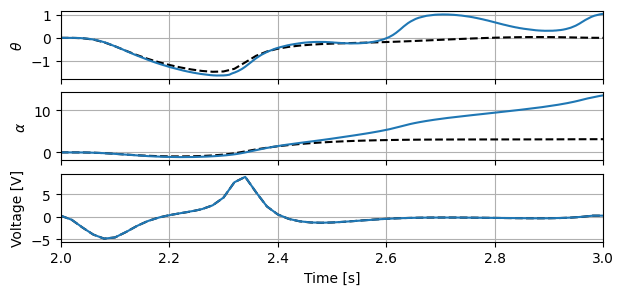

In [21]:
# Linearly interpolate the planned trajectory for online control
interp_fun = jax.vmap(jnp.interp, (None, None, 1))

# Offset by at least 2 seconds to make sure the timing is aligned
t_offset = 2.0

def nominal_trajectory_x(t):
    tp = t - t_offset
    return jnp.where(
        (tp > tf), xf,
        jnp.where(tp < 0.0, 0.0, interp_fun(tp, t_opt, x_opt))
    )

def nominal_trajectory_u(t):
    tp = t - t_offset
    return jnp.where(
        (tp > tf) | (tp < 0.0), 0.0, interp_fun(tp, t_opt, u_opt)
    )


dt = 1e-3   # 1 kHz control loop

builder = collimator.DiagramBuilder()
open_loop_voltage = library.SourceBlock(nominal_trajectory_u, name="u")
plant_hw = library.QuanserHAL(dt=dt, version=3, hardware=True)
builder.add(open_loop_voltage, plant_hw)
builder.connect(open_loop_voltage.output_ports[0], plant_hw.input_ports[0])

system = builder.build()
context = system.create_context()

recorded_signals = {
    "y": plant_hw.output_ports[0],
    "u": plant_hw.input_ports[0],
}

results = collimator.simulate(
    system,
    context,
    (0.0, tf + t_offset),
    recorded_signals=recorded_signals,
)

plant_hw.terminate()

t = results.time
y = results.outputs["y"]
u = results.outputs["u"]

fig, axs = plt.subplots(3, 1, figsize=(7, 3), sharex=True)
axs[0].plot(t_opt + t_offset, x_opt[:, 0], c="k", ls='--')
axs[0].plot(t, y[:, 0], c='tab:blue')
axs[0].grid()
axs[0].set_ylabel(r"$\theta$")
axs[1].plot(t_opt + t_offset, x_opt[:, 1], c="k", ls='--')
axs[1].plot(t, y[:, 1], c='tab:blue')
axs[1].grid()
axs[1].set_ylabel(r"$\alpha$")
axs[2].plot(t_opt + t_offset, u_opt, c="k", ls='--')
axs[2].plot(t, u, c='tab:blue')
axs[2].grid()
axs[2].set_ylabel("Voltage [V]")
axs[-1].set_xlabel("Time [s]")
axs[-1].set_xlim([t_offset, tf + t_offset])
plt.show()

In [22]:
# Simple matplotlib animation of what we recorded from the simulation
t, x = results.time, results.outputs["y"]

# Interpolate for plotting on uniform interval
t_plt = np.linspace(t[0], t[-1], 100)
x_plt = np.zeros((len(t_plt), 4))
for i in range(2):
    x_plt[:, i] = np.interp(t_plt, t, x[:, i])

animate_qube(t_plt, x_plt, parameters)

The open-loop trajectory starts off reasonably close to the planned behavior, but eventually the real system diverges from the planned behavior with the result that the pendulum either falls short of vertical or overshoots the vertical position.  This is typical of open-loop control; unless the model is very close to reality, the true system is fairly well-behaved, _and_ there are limited disturbances, the true behavior will tend to diverge from the intended outcome.

# Feedforward control

To compensate for this we can attempt to regulate the system to the _nominal_ trajectory, correcting for the divergence between the real system and the planned path.  We will do this by introducing a linear time-varying (LTV) system model, where the nonlinear dynamics model is linearized about the nominal trajectory at each instant in time.

We can apply an LQR controller to the LTV system, which will attempt to drive the tracking error to zero.  However, in contrast to the steady-state regulation problem, in this case we are operating on a fixed time horizon.  As a result, the feedback gain matrix $K$ is not fixed, but is the result of a forward-backwards simulation of an auxiliary dynamical system called the Riccatti equation.  This is conveniently implemented in the `FiniteHorizonLinearQuadraticRegulator` block, to which we just have to supply the nonlinear system, the nominal trajectory, and the normal LQR cost matrices.

As for the steady-state regulation problem, the LQR controller is based on _full-state_ feedback, but here we only have partial observations.  When we developed the LQG controller for disturbance rejection we estimated the full state using a linear Kalman filter.  However, over the full range of operating conditions this system is strongly nonlinear, so the standard Kalman filter estimate will quickly diverge.  Instead, we will estimate the full state using an _extended_ Kalman filter (EKF), a similar construction that just uses the nonlinear plant model to advance the state estimate instead of the linearized system.  This is implemented in the `ExtendedKalmanFilter` block, to which we supply the nonlinear plant, noise matrices, and an initial guess of the state.

<!-- TODO: Add diagram for feedforward control -->


In [23]:
def make_ffwd_swingup(dt, t0, tf, noise_amplitude=1e2, R=1e0, name="ffwd"):
    # LQR parameters
    Q = np.eye(nx)  # state penalty matrix
    # Q = np.diag([0.0, 1.0, 0.0, 1.0])
    Qf = Q  # terminal state penalty matrix
    N = np.zeros((nx, nu))  # cross cost matrix between state and control vectors

    # Kalman filter parameters
    G = np.eye(nu)
    QN = noise_amplitude * np.eye(nu)
    RN = np.eye(ny)

    ekf = library.ExtendedKalmanFilter.for_continuous_plant(
        library.QubeServoModel(full_state_output=False),
        dt=dt,
        G_func=lambda t: G,
        Q_func=lambda t: QN,
        R_func=lambda t: RN,
        x_hat_0=nominal_trajectory_x(0),
        P_hat_0=1e-4 * np.eye(nx),
        discretized_noise=True,
        name="ekf"
    )

    # create finite-horizon LQR controller with identical nominal and desired trajectories
    lqr = library.FiniteHorizonLinearQuadraticRegulator(
        t0,
        tf,
        library.QubeServoModel(full_state_output=True, name="qube"),
        Qf,
        func_Q=lambda t: Q,
        func_R=lambda t: R * np.eye(nu),
        func_N=lambda t: N,
        func_x_0=nominal_trajectory_x,
        func_u_0=nominal_trajectory_u,
        name="lqr",
    )

    builder = collimator.DiagramBuilder()
    builder.add(ekf, lqr)
    builder.connect(ekf.output_ports[0], lqr.input_ports[0])

    # Export inputs for (u, y)
    builder.export_input(ekf.input_ports[0], "u")
    builder.export_input(ekf.input_ports[1], "y")

    # Export outputs for (u, x_hat)
    builder.export_output(lqr.output_ports[0], "u")
    builder.export_output(ekf.output_ports[0], "x_hat")

    return builder.build(name=name)


Finally, we can't expect this feedforward controller to effectively balance the pendulum over a long period of time; instead we will switch to the same balancing controller we used with the energy-shaping swing-up controller.  We can reuse the dual-PID controller that has served us well so far, along with the switching logic.

In [24]:
def make_diagram(plant, dt, t0, tf, noise_amplitude=1e2, R=1e0):
    swingup_controller = make_ffwd_swingup(dt, t0, tf, noise_amplitude, R)
    balance_controller = make_pid(dt, y_eq=np.array([0.0, np.pi]))

    controller = make_switched_controller(swingup_controller, balance_controller, threshold=0.25)

    builder = collimator.DiagramBuilder()
    builder.add(plant, controller)
    builder.connect(plant.output_ports[0], controller.input_ports[0])
    builder.connect(controller.output_ports[0], plant.input_ports[0])

    return builder.build()

First let's test this in simulation.  We should see that the simulated system follows the planned trajectory very closely, since the planned trajectory is based on the same idealized model.

collimator:INFO max_major_steps=11998 based on smallest discrete period=0.001
collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=None, max_major_steps=11998, ode_solver_method=default, rtol=1e-06, atol=1e-08, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=2, return_context=True), Dopri5Solver(system=Diagram(root, 2 nodes), rtol=1e-06, atol=1e-08, max_step_size=None, min_step_size=None, method='default', enable_autodiff=False)


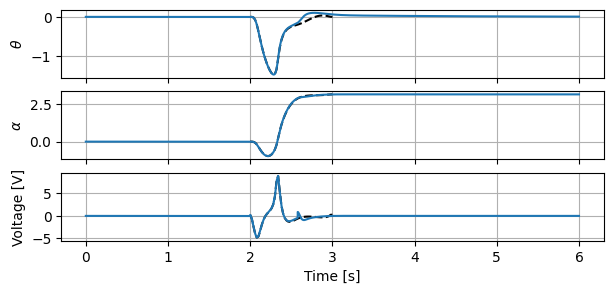

In [25]:
dt = 0.001  # 1 kHz control loop
t0 = 0.0
th = t_opt[-1] + t_offset  # Feedforward time horizon

plant = library.QubeServoModel(full_state_output=False, name="qube")
system = make_diagram(plant, dt, t0, th, R=1e1)
context = system.create_context()

recorded_signals = {
    "y": plant.output_ports[0],
    "u": plant.input_ports[0],
}

tf = 6.0
results = collimator.simulate(
    system,
    context,
    (0.0, tf),
    recorded_signals=recorded_signals,
)

t = results.time
y = results.outputs["y"]
u = results.outputs["u"]

fig, axs = plt.subplots(3, 1, figsize=(7, 3), sharex=True)
axs[0].plot(t_opt + t_offset, x_opt[:, 0], c="k", ls='--')
axs[0].plot(t, y[:, 0], c='tab:blue')
axs[0].grid()
axs[0].set_ylabel(r"$\theta$")
axs[1].plot(t_opt + t_offset, x_opt[:, 1], c="k", ls='--')
axs[1].plot(t, y[:, 1], c='tab:blue')
axs[1].grid()
axs[1].set_ylabel(r"$\alpha$")
axs[2].plot(t_opt + t_offset, u_opt, c="k", ls='--')
axs[2].plot(t, u, c='tab:blue')
axs[2].grid()
axs[2].set_ylabel("Voltage [V]")
axs[-1].set_xlabel("Time [s]")
plt.show()

In [26]:
# Interpolate for plotting on uniform interval
t_plt = np.linspace(t_offset, t[-1], 100)
x_plt = np.zeros((len(t_plt), 4))
for i in range(2):
    x_plt[:, i] = np.interp(t_plt, t, y[:, i])

animate_qube(t_plt, x_plt, parameters)

At least the simulation is doing what we expect, but again, this is no more than a sanity check.  For the real test, we need to test the controller out on the hardware:

Initialized Qube


collimator:INFO max_major_steps=11998 based on smallest discrete period=0.001
collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=None, max_major_steps=11998, ode_solver_method=default, rtol=1e-06, atol=1e-08, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=2, return_context=True), Dopri5Solver(system=Diagram(root, 2 nodes), rtol=1e-06, atol=1e-08, max_step_size=None, min_step_size=None, method='default', enable_autodiff=False)


Restoring sigint handler


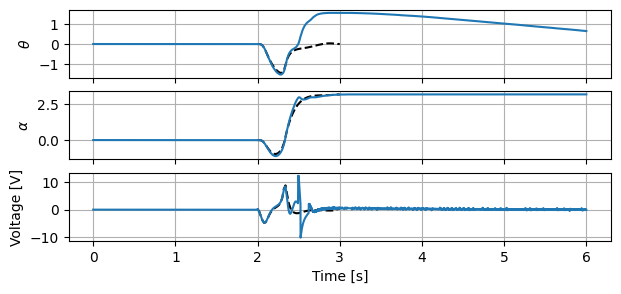

In [29]:
dt = 0.001  # 1 kHz control loop
t0 = 0.0
th = t_opt[-1] + t_offset  # Feedforward time horizon

plant_hw = library.QuanserHAL(dt=dt, version=version, hardware=HARDWARE)
system = make_diagram(plant_hw, dt, t0, th, R=1e1)
context = system.create_context()

recorded_signals = {
    "y": plant_hw.output_ports[0],
    "u": plant_hw.input_ports[0],
}

tf = 6.0
results = collimator.simulate(
    system,
    context,
    (0.0, tf),
    recorded_signals=recorded_signals,
)
plant_hw.terminate()

t = results.time
y = results.outputs["y"]
u = results.outputs["u"]

fig, axs = plt.subplots(3, 1, figsize=(7, 3), sharex=True)
axs[0].plot(t_opt + t_offset, x_opt[:, 0], c="k", ls='--')
axs[0].plot(t, y[:, 0], c='tab:blue')
axs[0].grid()
axs[0].set_ylabel(r"$\theta$")
axs[1].plot(t_opt + t_offset, x_opt[:, 1], c="k", ls='--')
axs[1].plot(t, y[:, 1], c='tab:blue')
axs[1].grid()
axs[1].set_ylabel(r"$\alpha$")
axs[2].plot(t_opt + t_offset, u_opt, c="k", ls='--')
axs[2].plot(t, u, c='tab:blue')
axs[2].grid()
axs[2].set_ylabel("Voltage [V]")
axs[-1].set_xlabel("Time [s]")
plt.show()

In [28]:
# Interpolate for plotting on uniform interval
t_plt = np.linspace(t_offset, tf, 100)
x_plt = np.zeros((len(t_plt), 4))
for i in range(2):
    x_plt[:, i] = np.interp(t_plt, t, y[:, i])

animate_qube(t_plt, x_plt, parameters)

The system overshoots the target rotor position a bit before starting to recover, but the main thing is that it performs the swing-up quickly and then switches to the balancing controller to stabilize the "up" position.  The result is a much more aggressive maneuver compared to the energy-shaping control, and more importantly, a much more general control strategy that we can apply to strongly nonlinear systems subject to parametric uncertainty, environmental disturbances, and measurement noise.